# 实战Kaggle比赛：预测房价
实现几个函数来方便下载数据集, 首先，我们建立字典DATA_HUB， 它可以将数据集名称的字符串映射到数据集相关的二元组上， 这个二元组包含数据集的url和验证文件完整性的sha-1密钥。 所有类似的数据集都托管在地址为DATA_URL的站点上。

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。 如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 我们将使用缓存的文件，以避免重复的下载。

In [3]:
import hashlib
import os
import tarfile
import zipfile
import requests

#@save
DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

def download(name, cache_dir=os.path.join('..', 'data/kaggleHousePred')):  #@save
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    os.makedirs(cache_dir, exist_ok=True)
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

#我们还需实现两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [4]:
def download_extract(name, folder=None):  #@save
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():  #@save
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

# 使用pandas读入并处理数据

In [5]:
# 如果你没有安装pandas，请取消下一行的注释
# !pip install pandas

%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

DATA_HUB['kaggle_house_train'] = (  #@save
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (  #@save
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

# 前四个和最后两个特征，以及相应标签（房价）

In [6]:
print(train_data.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


我们可以看到，在每个样本中，第一个特征是ID， 这有助于模型识别每个训练样本。 虽然这很方便，但它不携带任何用于预测的信息。 因此，在将数据提供给模型之前，我们将其从数据集中删除。

In [7]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))
print(all_features.iloc[0:4, [0,1,2,3,-3,-2,-1]])

   MSSubClass MSZoning  LotFrontage  LotArea  YrSold SaleType SaleCondition
0          60       RL         65.0     8450    2008       WD        Normal
1          20       RL         80.0     9600    2007       WD        Normal
2          60       RL         68.0    11250    2008       WD        Normal
3          70       RL         60.0     9550    2006       WD       Abnorml


# 数据预处理
首先，我们将所有缺失的值替换为相应特征的平均值。然后，为了将所有特征放在一个共同的尺度上， 我们通过将特征重新缩放到零均值和单位方差来标准化数据：

In [8]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

我们处理离散值。 这包括诸如“MSZoning”之类的特征。 我们用独热编码替换它们

In [9]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

你可以看到，此转换会将特征的总数量从79个增加到331个。 最后，通过values属性，我们可以 从pandas格式中提取NumPy格式，并将其转换为张量表示用于训练。

In [10]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

#训练

In [11]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

房价就像股票价格一样，我们关心的是相对数量，而不是绝对数量。 因此，[我们更关心相对误差$\frac{y - \hat{y}}{y}$，] 而不是绝对误差$y - \hat{y}$。 例如，如果我们在俄亥俄州农村地区估计一栋房子的价格时， 假设我们的预测偏差了10万美元， 然而那里一栋典型的房子的价值是12.5万美元， 那么模型可能做得很糟糕。 另一方面，如果我们在加州豪宅区的预测出现同样的10万美元的偏差， （在那里，房价中位数超过400万美元） 这可能是一个不错的预测。

In [12]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

我们的训练函数将借助Adam优化器 （我们将在后面章节更详细地描述它）。 Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [13]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

#K折交叉验证

In [14]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

当我们在$K$折交叉验证中训练$K$次后，返回训练和验证误差的平均值。

In [15]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

# 模型选择

折1，训练log rmse0.170207, 验证log rmse0.156259
折2，训练log rmse0.162634, 验证log rmse0.194766
折3，训练log rmse0.164099, 验证log rmse0.168334
折4，训练log rmse0.168350, 验证log rmse0.155037
折5，训练log rmse0.162689, 验证log rmse0.183042
5-折验证: 平均训练log rmse: 0.165596, 平均验证log rmse: 0.171487


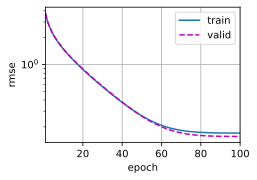

In [16]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

# 提交你的Kaggle预测

训练log rmse：0.162487


AttributeError: 'Tensor' object has no attribute 'asnumpy'

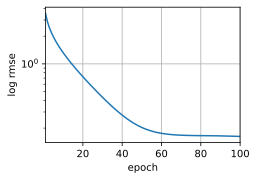

In [18]:
def train_and_pred(train_features, test_features, train_labels, test_data, num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None, num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).asnumpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

train_and_pred(train_features, test_features, train_labels, test_data,
           num_epochs, lr, weight_decay, batch_size)